# Final Combined Model

**Description:** Polarity + Stress + Sarcasm + Baseline

## 5. Mount Shared Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
max_length = 50

#### 5.1 Load Polarity Model

In [3]:
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install pydot --quiet
!pip install transformers --quiet

     |████████████████████████████████| 24.2 MB 770 kB/s 
     |████████████████████████████████| 4.9 MB 13.0 MB/s 
     |████████████████████████████████| 4.7 MB 14.2 MB/s 
     |████████████████████████████████| 596 kB 57.1 MB/s 
     |████████████████████████████████| 6.6 MB 63.9 MB/s 
     |████████████████████████████████| 101 kB 12.6 MB/s 


In [4]:

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text


import sklearn as sk
import os
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib.pyplot as plt

import re
import gensim


from transformers import BertTokenizer, TFBertModel

import pandas as pd
import numpy as np

import transformers
# from transformers import BertTokenizer, TFBertModel
import tqdm
from keras.preprocessing import sequence
import tensorflow_text as tf_text

In [5]:
## Load polarity model
def create_polarity_model(train_layers=-1,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):

    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False

    #Inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer_polarity')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer_polarity')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer_polarity')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs)


    pooled_token = bert_out[1]

    #Dense Hidden Layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_polarity')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer_polarity')(hidden)

    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 


    return classification_model

In [6]:
polarity_model_path = '/content/drive/MyDrive/wzx/polarity_model/yelp_polarity_best_weights.h5'


polarity_model = create_polarity_model()
polarity_model.load_weights(polarity_model_path)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
polarity_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer_polarity   [(None, 50)]        0           []                               
 (InputLayer)                                                                                     
                                                                                                  
 input_ids_layer_polarity (Inpu  [(None, 50)]        0           []                               
 tLayer)                                                                                          
                                                                                                  
 token_type_ids_layer_polarity   [(None, 50)]        0           []                               
 (InputLayer)                                                                                 

#### 5.2 Load Sarcasm Model

In [8]:
def create_sarcasm_model(train_layers=-1,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):

    model_checkpoint = 'bert-base-cased'
    bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
    bert_model = TFBertModel.from_pretrained(model_checkpoint)



    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer_sarcasm') 
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer_sarcasm')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer_sarcasm')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs) 

    pooled_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_sarcasm')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer_sarcasm')(hidden)

    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics='accuracy') 


    

    ### END YOUR CODE
    return classification_model

In [9]:
sarcasm_model_path = '/content/drive/My Drive/wzx/sarcasm_model/sarcasm_best_weights.h5' #F"/content/gdrive/My Drive/wzx/{model_save_name}" 

sarcasm_model = create_sarcasm_model()
sarcasm_model.load_weights(sarcasm_model_path)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [10]:
sarcasm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer_sarcasm (  [(None, 50)]        0           []                               
 InputLayer)                                                                                      
                                                                                                  
 input_ids_layer_sarcasm (Input  [(None, 50)]        0           []                               
 Layer)                                                                                           
                                                                                                  
 token_type_ids_layer_sarcasm (  [(None, 50)]        0           []                               
 InputLayer)                                                                                

#### 5.3 Load Stress Model

In [11]:
# import packages
import pandas as pd
import numpy as np
import tensorflow as tf
import transformers
from transformers import BertTokenizer, TFBertModel
import tqdm
from keras.preprocessing import sequence
import tensorflow_text as tf_text

In [12]:
#### Load Stress model
def create_stress_model(hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005,               
                      ):
    """
    Build a simple classification model with BERT
    """

    bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-cased')
    # Inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer_stress') 
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer_stress')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer_stress')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs) 

    # Take average of classification token
    avg_token = tf.math.reduce_mean(bert_out[0],axis=1)

    # Dense Hidden Layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_stress')(avg_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    # concat_layer = tf.keras.layers.concatenate([layer1, layer2, layer3])
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer_stress')(hidden)

    # Model Input & Output
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 

    ### END YOUR CODE
    
    return classification_model

In [13]:
stress_model_path = '/content/drive/MyDrive/wzx/stress_model/stress_weights.h5'

stress_model = create_stress_model()
stress_model.load_weights(stress_model_path)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
stress_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer_stress (I  [(None, 50)]        0           []                               
 nputLayer)                                                                                       
                                                                                                  
 input_ids_layer_stress (InputL  [(None, 50)]        0           []                               
 ayer)                                                                                            
                                                                                                  
 token_type_ids_layer_stress (I  [(None, 50)]        0           []                               
 nputLayer)                                                                                 

# Support-Only Model

In [25]:
train = pd.read_csv('/content/drive/MyDrive/wzx/data/train_amazon_full.csv')#.sample(n = 1000)
test = pd.read_csv('/content/drive/MyDrive/wzx/data/test_amazon_full.csv')#.sample(n = 1000)
valid = pd.read_csv('/content/drive/MyDrive/wzx/data/valid_amazon_full.csv')#.sample(n = 1000)


train['reviewText'] = train['reviewText'].astype(str)
valid['reviewText'] = valid['reviewText'].astype(str)
test['reviewText'] = test['reviewText'].astype(str)

Generate Input Data

In [26]:


%%time

train_texts = list(train.reviewText.values)
train_labels = list(train.rating_label.values)

valid_texts = list(valid.reviewText.values)
valid_labels = list(valid.rating_label.values)

test_texts = list(test.reviewText.values)
test_labels = list(test.rating_label.values)

train_labels = np.asarray(train_labels)
valid_labels = np.asarray(valid_labels)
test_labels = np.asarray(test_labels)


max_length = 50

# Polarity Model Input

polarity_model_checkpoint = 'bert-base-cased'
polarity_tokenizer = BertTokenizer.from_pretrained(polarity_model_checkpoint)

train_encodings_polarity = polarity_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings_polarity = polarity_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings_polarity = polarity_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')


# Sarcasm Model Input


sarcasm_model_checkpoint = 'bert-base-cased'
sarcasm_tokenizer = BertTokenizer.from_pretrained(sarcasm_model_checkpoint)

train_encodings_sarcasm = sarcasm_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings_sarcasm = sarcasm_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings_sarcasm = sarcasm_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')


# Stress Model Input

stress_model_checkpoint = 'bert-large-uncased'
stress_tokenizer = BertTokenizer.from_pretrained(stress_model_checkpoint)

train_encodings_stress = stress_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings_stress = stress_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings_stress = stress_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')




CPU times: user 2h 59min 54s, sys: 38.7 s, total: 3h 33s
Wall time: 3h 3s


In [20]:

def create_ensemble_model(hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005,               
                      ):


    

    concat_layer = tf.keras.layers.concatenate([polarity_model.layers[-2].output, 
                                                sarcasm_model.layers[-2].output, 
                                                stress_model.layers[-2].output
                                                ], axis =1)


    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_ensemble')(concat_layer)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_ensemble')(hidden)

    # Model Input & Output
    classification_model = tf.keras.Model(inputs=[polarity_model.input, 
                                                  sarcasm_model.input, 
                                                  stress_model.input], 
                                          
                                          outputs=[classification])
    
    for layer in classification_model.layers[:-3]:
        layer.trainable=False
        for w in layer.weights: w._trainable=False

    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 
    
    
    return classification_model

In [ ]:
checkpoint_path = '/content/drive/My Drive/wzx/ensemble_amazon_full_best_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_path ,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

ensemble_model = create_ensemble_model()

polarity_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]
sarcasm_train_input = [train_encodings_sarcasm.input_ids, train_encodings_sarcasm.token_type_ids, train_encodings_sarcasm.attention_mask]
stress_train_input = [train_encodings_stress.input_ids, train_encodings_stress.token_type_ids, train_encodings_stress.attention_mask]

polarity_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]
sarcasm_valid_input= [valid_encodings_sarcasm.input_ids, valid_encodings_sarcasm.token_type_ids, valid_encodings_sarcasm.attention_mask]
stress_valid_input = [valid_encodings_stress.input_ids, valid_encodings_stress.token_type_ids, valid_encodings_stress.attention_mask]

polarity_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]
sarcasm_test_input = [test_encodings_sarcasm.input_ids, test_encodings_sarcasm.token_type_ids, test_encodings_sarcasm.attention_mask]
stress_test_input = [test_encodings_stress.input_ids, test_encodings_stress.token_type_ids, test_encodings_stress.attention_mask]


ensemble_model_history = ensemble_model.fit([polarity_train_input, sarcasm_train_input, stress_train_input], 
                                                  train_labels,
                                                  validation_data=([polarity_valid_input, sarcasm_valid_input, stress_valid_input], 
                                                  valid_labels),
                             
                                                  batch_size=128, 
                                                  epochs=10,
                                                  callbacks=[model_checkpoint_callback]
                                                  ) 




In [ ]:
print('Complete Training')

In [ ]:
score = ensemble_model.evaluate([polarity_test_input, sarcasm_test_input, stress_test_input], 
                                                  test_labels) 

print('Test loss:', score[0]) 
print('Test accuracy:', np.round(score[1], 5))

# Ensemble V2 (Final Ensemble Model - 4 submodels)

In [15]:
## Load baseline model
def create_baseline_model(train_layers=-1,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):

    bert_model = TFBertModel.from_pretrained('bert-base-cased')


    #Inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer_baseline')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer_baseline')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer_baseline')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs)


    pooled_token = bert_out[1]

    #Dense Hidden Layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_baseline')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer_baseline')(hidden)

    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 


    return classification_model

In [16]:
baseline_model_path = '/content/drive/MyDrive/wzx/baseline/baseline_amazon_full_best_weights.h5'

baseline_model = create_baseline_model()
baseline_model.load_weights(baseline_model_path)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:

def create_ensemble_v2(hidden_size = 50, 
                          dropout=0.3,
                          learning_rate=0.00005,               
                      ):

    concat_layer = tf.keras.layers.concatenate([polarity_model.layers[-2].output, 
                                                sarcasm_model.layers[-2].output, 
                                                stress_model.layers[-2].output,
                                                baseline_model.layers[-2].output
                                                ], axis =1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_ensemble_v2')(concat_layer)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_ensemble_v2')(hidden)

    # Model Input & Output
    classification_model = tf.keras.Model(inputs=[polarity_model.input, 
                                                  sarcasm_model.input, 
                                                  stress_model.input,
                                                  baseline_model.input
                                                  ], 
                                          
                                          outputs=[classification])
    
    # Freeze the sentiment layers except the ensemble layer
    for layer in classification_model.layers[:-3]:
        layer.trainable=False
        for w in layer.weights: w._trainable=False


    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 
    
    
    return classification_model

In [32]:
checkpoint_path = '/content/drive/My Drive/wzx/ensemble_amazon_full_v2_best_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_path ,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

ensemble_v2 = create_ensemble_v2()

polarity_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]
sarcasm_train_input = [train_encodings_sarcasm.input_ids, train_encodings_sarcasm.token_type_ids, train_encodings_sarcasm.attention_mask]
stress_train_input = [train_encodings_stress.input_ids, train_encodings_stress.token_type_ids, train_encodings_stress.attention_mask]
baseline_train_input = [train_encodings_polarity.input_ids, train_encodings_polarity.token_type_ids, train_encodings_polarity.attention_mask]

polarity_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]
sarcasm_valid_input= [valid_encodings_sarcasm.input_ids, valid_encodings_sarcasm.token_type_ids, valid_encodings_sarcasm.attention_mask]
stress_valid_input = [valid_encodings_stress.input_ids, valid_encodings_stress.token_type_ids, valid_encodings_stress.attention_mask]
baseline_valid_input = [valid_encodings_polarity.input_ids, valid_encodings_polarity.token_type_ids, valid_encodings_polarity.attention_mask]

polarity_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]
sarcasm_test_input = [test_encodings_sarcasm.input_ids, test_encodings_sarcasm.token_type_ids, test_encodings_sarcasm.attention_mask]
stress_test_input = [test_encodings_stress.input_ids, test_encodings_stress.token_type_ids, test_encodings_stress.attention_mask]
baseline_test_input = [test_encodings_polarity.input_ids, test_encodings_polarity.token_type_ids, test_encodings_polarity.attention_mask]


ensemble_v2_history = ensemble_v2.fit([polarity_train_input, sarcasm_train_input, stress_train_input, baseline_train_input], 
                                                  train_labels,
                                                  validation_data=([polarity_valid_input, sarcasm_valid_input, stress_valid_input, baseline_valid_input], 
                                                  valid_labels),
                          
                                                  batch_size=128, 
                                                  epochs=5,
                                                  callbacks=[model_checkpoint_callback]
                                                  ) 

Epoch 1/5
10683/10683 [==============================] - 7487s 699ms/step - loss: 0.1164 - accuracy: 0.9614 - val_loss: 0.1668 - val_accuracy: 0.9412
Epoch 2/5
10683/10683 [==============================] - 7448s 697ms/step - loss: 0.0875 - accuracy: 0.9700 - val_loss: 0.1668 - val_accuracy: 0.9411
Epoch 3/5
10683/10683 [==============================] - 7449s 697ms/step - loss: 0.0866 - accuracy: 0.9700 - val_loss: 0.1623 - val_accuracy: 0.9412
Epoch 4/5
10683/10683 [==============================] - 7462s 698ms/step - loss: 0.0861 - accuracy: 0.9702 - val_loss: 0.1648 - val_accuracy: 0.9413
Epoch 5/5
10683/10683 [==============================] - 7453s 698ms/step - loss: 0.0859 - accuracy: 0.9701 - val_loss: 0.1642 - val_accuracy: 0.9412


In [33]:
print('Complete Training')

Complete Training


In [18]:
ensemble_v2_path = '/content/drive/My Drive/wzx/ensemble_amazon_full_v2_best_weights.h5'
ensemble_v2 = create_ensemble_v2()
ensemble_v2.load_weights(ensemble_v2_path)


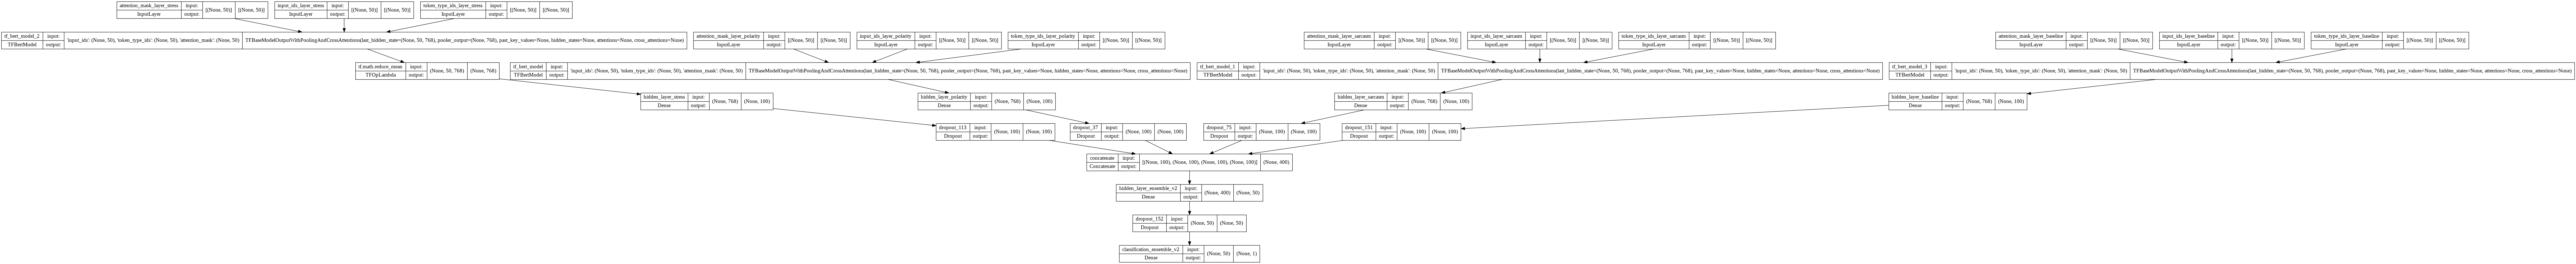

In [19]:
keras.utils.plot_model(ensemble_v2, "ensemble_architecture.png", show_shapes=True)

In [38]:
score = ensemble_v2.evaluate([polarity_test_input, sarcasm_test_input, stress_test_input, baseline_test_input], 
                                                  test_labels) 

print('Test loss:', score[0]) 
print('Test accuracy:', np.round(score[1], 5))

14244/14244 [==============================] - 2067s 145ms/step - loss: 0.1652 - accuracy: 0.9416
Test loss: 0.1651684045791626
Test accuracy: 0.94161


In [36]:
import pandas as pd
import numpy as np

import pandas as pd
def generate_txt_pred(model, model_input, text, truth):
  pred_prob = predict_on_batch_step(model, model_input)
  pred_prob = list(pred_prob)
  output = pd.DataFrame({
      'Text': text, 
      'Predicted_Prob': pred_prob,
      'Label': truth
                        }
                        )
  output['Predicted_Label'] = output['Predicted_Prob'].round(0)
  output['Correct'] = output['Predicted_Label'] == output['Label']
  return output



def predict_on_batch_step(model, model_input):
  polarity_test_input, sarcasm_test_input, stress_test_input, baseline_test_input = model_input

  length = len(test_encodings_polarity.input_ids)
  batch_size = 3000
  n = int(length / batch_size)
  last_batch_size = length % batch_size


  arr = []
  for i in range(n):
    print(i)

    tmp = model.predict_on_batch([test_encodings_polarity.input_ids[i*batch_size:(i+1)*batch_size], test_encodings_polarity.token_type_ids[i*batch_size:(i+1)*batch_size], test_encodings_polarity.attention_mask[i*batch_size:(i+1)*batch_size],
                                  test_encodings_sarcasm.input_ids[i*batch_size:(i+1)*batch_size], test_encodings_sarcasm.token_type_ids[i*batch_size:(i+1)*batch_size], test_encodings_sarcasm.attention_mask[i*batch_size:(i+1)*batch_size],
                                  test_encodings_stress.input_ids[i*batch_size:(i+1)*batch_size], test_encodings_stress.token_type_ids[i*batch_size:(i+1)*batch_size], test_encodings_stress.attention_mask[i*batch_size:(i+1)*batch_size],
                                  test_encodings_polarity.input_ids[i*batch_size:(i+1)*batch_size], test_encodings_polarity.token_type_ids[i*batch_size:(i+1)*batch_size], test_encodings_polarity.attention_mask[i*batch_size:(i+1)*batch_size]
                                  ])
    tmp = list(np.concatenate(tmp).flat)
    arr += tmp

  tmp = model.predict_on_batch([test_encodings_polarity.input_ids[(i+1)*batch_size:], test_encodings_polarity.token_type_ids[(i+1)*batch_size:], test_encodings_polarity.attention_mask[(i+1)*batch_size:],
                                  test_encodings_sarcasm.input_ids[(i+1)*batch_size:], test_encodings_sarcasm.token_type_ids[(i+1)*batch_size:], test_encodings_sarcasm.attention_mask[(i+1)*batch_size:],
                                  test_encodings_stress.input_ids[(i+1)*batch_size:], test_encodings_stress.token_type_ids[(i+1)*batch_size:], test_encodings_stress.attention_mask[(i+1)*batch_size:],
                                  test_encodings_polarity.input_ids[(i+1)*batch_size:], test_encodings_polarity.token_type_ids[(i+1)*batch_size:], test_encodings_polarity.attention_mask[(i+1)*batch_size:]
                                  ])
  tmp = list(np.concatenate(tmp).flat)
  arr += tmp

  return arr

In [37]:
ensemble_input = [polarity_test_input, sarcasm_test_input, stress_test_input, baseline_test_input]
test_ensemble = generate_txt_pred(ensemble_v2, ensemble_input, test_texts, test_labels)
test_ensemble.to_csv('/content/drive/MyDrive/wzx/baseline/ensemble_amazon_full_v2_test_output.csv', index = False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
